<a href="https://colab.research.google.com/github/ahmedtarek-/MNS_CP_2022/blob/main/stochastic_channel/Stochastic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# H-H-He-He-He-Hel-Hell-Hello Stochastic


## 1) K+ channel 

#### 1.1) Defining the potassium channel object

In [1]:
from random import uniform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')

class StochasticKChannel:
  def __init__(self, initial_state=1, voltage=-50, delta_t=0.1):
    self.state = initial_state
    self.voltage = voltage
    self.delta_t = delta_t

  def update_voltage(self, voltage):
    self.voltage = voltage

  def update_delta_t(self, delta_t):
    self.delta_t = delta_t

  def alpha_n(self):
    alpha = (0.01* (self.voltage +  55)) / (1 - np.exp(-0.1 * (self.voltage + 55) ))
    # print("Alpha: {}".format(alpha))
    return alpha * self.delta_t

  def beta_n(self):
    beta = 0.125 * np.exp(-0.0125 * (self.voltage + 65) )
    # print("Beta: {}".format(beta))
    return beta * self.delta_t


  def state_1_transition(self):
    """
      Probability to leave and go to S2: 4*alpha_n
    """
    random_1 = uniform(0, 1)
    p_leave = 4*self.alpha_n()
    # print("Prob to leave state 1: {} (rand: {})".format(p_leave, random_1))
    if random_1 <= p_leave:
      self.state = 2
      return True
    return False

  def state_2_transition(self):
    """
      Probability to leave: 3*alpha_n + beta_n
      Probability to go to S3: 3*alpha_n / (3*alpha_n + beta_n)
      Probability to go to S1: 1- (3*alpha_n / (3*alpha_n + beta_n))
    """
    random_1 = uniform(0, 1)
    random_2 = uniform(0, 1)
    p_leave = 3*self.alpha_n() + self.beta_n()
    p_s3 = 3*self.alpha_n() / (3*self.alpha_n() + self.beta_n())
    if random_1 > p_leave:
      return False  # Stay in state 1
    if random_2 <= p_s3:
      self.state = 3
    else:
      self.state = 1
    return True

  def state_3_transition(self):
    random_1 = uniform(0, 1)
    random_2 = uniform(0, 1)
    p_leave = 2*self.alpha_n() + 2*self.beta_n()
    p_s4 = 2*self.alpha_n() / (2*self.alpha_n() + 2*self.beta_n())
    if random_1 > p_leave:
      return False  # Stay in state 1
    if random_2 <= p_s4:
      self.state = 4
    else:
      self.state = 2
    return True

  def state_4_transition(self):
    random_1 = uniform(0, 1)
    random_2 = uniform(0, 1)
    p_leave = self.alpha_n() + 3*self.beta_n()
    p_s5 = self.alpha_n() / (self.alpha_n() + 3*self.beta_n())
    if random_1 > p_leave:
      return False  # Stay in state 1
    if random_2 <= p_s5:
      self.state = 5
    else:
      self.state = 3
    return True

  def state_5_transition(self):
    random_1 = uniform(0, 1)
    if random_1 <= 4*self.beta_n():
      self.state = 4
      return True
    return False

  def P(self):
    if self.state == 5:
      return 1
    else:
      return 0

  def next_state(self):
    if self.state == 1:
      self.state_1_transition()
    elif self.state ==  2:
      self.state_2_transition()
    elif self.state == 3:
      self.state_3_transition()
    elif self.state == 4:
      self.state_4_transition()
    elif self.state ==  5:
      self.state_5_transition()
    return self.P()

  def go_stochastic(self, t_max=0, delta_t=0):
    self.delta_t = delta_t
    t = delta_t
    on_off = []
    while t <= t_max:
      on_off.append(self.P())
      self.next_state()
      t += delta_t
    return on_off

channel = StochasticKChannel(initial_state=1, voltage=10)
print("initial: {}".format(channel.state))
channel.next_state()
print("after one move: {}".format(channel.state))

initial: 1
after one move: 1


#### 1.2) Trying out the Stochastic time relation

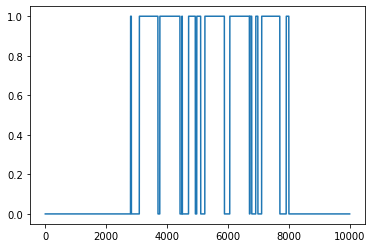

In [2]:
t_max   = 20      # 20 mS
delta_t = 0.01
channel = StochasticKChannel(initial_state=1, voltage=-100)
output_i = channel.go_stochastic(t_max=20, delta_t=delta_t)

channel = StochasticKChannel(initial_state=1, voltage=10)
output_ii = channel.go_stochastic(t_max=60, delta_t=delta_t)

channel = StochasticKChannel(initial_state=1, voltage=-100)
output_iii = channel.go_stochastic(t_max=20, delta_t=delta_t)

outputs = output_i + output_ii + output_iii


plt.plot(outputs)
plt.show()

## 2) Na+ channel 

#### 2.1) Defining the Sodium channel object



In [3]:
class StochasticNAChannel:
  k1_rate = 0.24        # 1/ms
  k3_rate = 1.5         # 1/ms
  k2_rate = 0.4         # 1/ms

  def __init__(self, initial_state=1, voltage=-50, delta_t=0.1):
    self.state = initial_state
    self.voltage = voltage
    self.delta_t = delta_t

  def update_voltage(self, voltage):
    self.voltage = voltage

  def update_delta_t(self, delta_t):
    self.delta_t = delta_t

  def alpha_m(self):
    alpha = (0.1* (self.voltage +  40)) / (1 - np.exp(-0.1 * (self.voltage + 40) ))
    return alpha * self.delta_t

  def beta_m(self):
    beta = 4 * np.exp(-0.0556 * (self.voltage + 65) )
    return beta * self.delta_t

  def alpha_h(self):
    alpha = 0.07*np.exp(-0.05 * (self.voltage + 65))
    return alpha * self.delta_t

  def beta_h(self):
    beta = 1 / (1 + np.exp(-0.1 * (self.voltage + 35) ))
    return beta * self.delta_t

  def k1(self):
    return self.k1_rate * self.delta_t

  def k2(self):
    return self.k2_rate * self.delta_t
  
  def k3(self):
    return self.k3_rate * self.delta_t

  def state_1_transition(self):
    """
      Probability to leave and go to S2: 3*alpha_m
    """
    random_1 = uniform(0, 1)
    p_leave = 3*self.alpha_m()
    # print("Prob to leave state 1: {} (rand: {})".format(p_leave, random_1))
    if random_1 <= p_leave:
      self.state = 2
      return True
    return False

  def state_2_transition(self):
    """
      Probability to leave: 3*alpha_n + beta_n
      Probability to go to S3: 3*alpha_n / (3*alpha_n + beta_n)
      Probability to go to S1: 1- (3*alpha_n / (3*alpha_n + beta_n))
    """
    random_1 = uniform(0, 1)
    p_leave = 2*self.alpha_m() + self.beta_m() + self.k1()
    if random_1 > p_leave:
      return False                                            # Stay in state 2
    p_s3 = 2*self.alpha_m() / p_leave
    p_s1 = (self.beta_m() + 2*self.alpha_m()) / p_leave
    random_2 = uniform(0, 1)
    if random_2 <= p_s3:
      self.state = 3
    elif random_2 <= p_s1:
      self.state = 1
    else:
      self.state = 5
    return True

  def state_3_transition(self):
    random_1 = uniform(0, 1)
    p_leave = self.alpha_m() + 2*self.beta_m() + self.k2()
    if random_1 > p_leave:
      return False                                             # Stay in state 3
    p_s4 = self.alpha_m() / p_leave
    p_s2 = (2*self.beta_m() + self.alpha_m()) / p_leave
    random_2 = uniform(0, 1)
    if random_2 <= p_s4:
      self.state = 4
    elif random_2 <= p_s2:
      self.state = 2
    else:
      self.state = 5
    return True

  def state_4_transition(self):
    random_1 = uniform(0, 1)
    p_leave = self.k3() + 3*self.beta_m()
    if random_1 > p_leave:
      return False                                             # Stay in state 1
    random_2 = uniform(0, 1)
    p_s5 = self.k3() / p_leave
    if random_2 <= p_s5:
      self.state = 5
    else:
      self.state = 3
    return True

  def state_5_transition(self):
    random_1 = uniform(0, 1)
    if random_1 <= self.alpha_h():
      self.state = 3
      return True
    return False

  def P(self):
    if self.state == 4:
      return 1
    else:
      return 0

  def next_state(self):
    if self.state == 1:
      self.state_1_transition()
    elif self.state ==  2:
      self.state_2_transition()
    elif self.state == 3:
      self.state_3_transition()
    elif self.state == 4:
      self.state_4_transition()
    elif self.state ==  5:
      self.state_5_transition()
    return self.P()

  def go_stochastic(self, t_max=0, delta_t=0):
    self.delta_t = delta_t
    t = delta_t
    on_off = []
    while t <= t_max:
      on_off.append(self.P())
      self.next_state()
      t += delta_t
    return on_off

channel = StochasticNAChannel(initial_state=1, voltage=10, delta_t=0.01)
print("initial: {}".format(channel.state))
channel.next_state()
print("after one transition: {}".format(channel.state))


initial: 1
after one transition: 1


#### 2.1) Calculating and plotting the behaviour of one NA channel

calculated mean = 0.007601520304060812
expected mean = 0.0016020252408374166


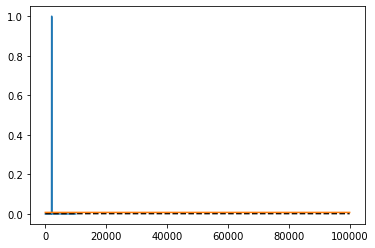

1.0768704938599587


In [4]:
t_max   = 20      # 20 mS
delta_t = 0.01
channel = StochasticNAChannel(initial_state=1, voltage=-100)
output_i = channel.go_stochastic(t_max=20, delta_t=delta_t)

channel = StochasticNAChannel(initial_state=1, voltage=10)
output_ii = channel.go_stochastic(t_max=60, delta_t=delta_t)

channel = StochasticNAChannel(initial_state=1, voltage=-100)
output_iii = channel.go_stochastic(t_max=20, delta_t=delta_t)

outputs = output_i + output_ii + output_iii

def alpha_m(voltage):
  alpha = (0.1* (voltage +  40)) / (1 - np.exp(-0.1 * (voltage + 40) ))
  # print("Alpha: {}".format(alpha))
  return alpha

def beta_m(voltage):
  beta = 4 * np.exp(-0.0556 * (voltage + 65) )
  # print("Beta: {}".format(beta))
  return beta

def alpha_h(voltage):
  alpha = 0.07*np.exp(-0.05 * (voltage + 65))
  # print("Alpha: {}".format(alpha))
  return alpha
  
def beta_h(voltage):
  beta = 1 / (1 + np.exp(-0.1 * (voltage + 35) ))
  # print("Beta: {}".format(beta))
  return beta

def m_inf(voltage):
  m_inf = alpha_m(voltage) / (alpha_m(voltage) + beta_m(voltage))
  return m_inf

def tao_m(voltage):
  return 1 / (alpha_m(voltage) + beta_m(voltage))

def h_inf(voltage):
  h_inf = alpha_h(voltage) / (alpha_h(voltage) + beta_h(voltage))
  return h_inf

def tao_h(voltage):
  return 1 / (alpha_h(voltage) + beta_h(voltage))

expected_mean=[m_inf(10)**3*h_inf(10) for x in range(100000)]
mean=np.mean(outputs)
mean_calculated=[mean for x in range(100000)]
print(f'calculated mean = {mean}')
print(f'expected mean = {expected_mean[0]}')

#I think the difference in means is quite large but then again I am not sure as it changes every time
#sometimes we have good numbers and other times our prediction is larger than the expected one
plt.plot(outputs)
plt.plot(expected_mean, ls='--', c='k')
plt.plot(mean_calculated)
#plt.plot(tao_h)
plt.show()
print(tao_h(-10))

## 3) Defining a population class

This lets us update the voltage after a whole population of channels have changed their *state*

In [5]:

class StochasticPopulation:
  def __init__(self, k_population=[], na_population=[], initial_voltage=0, delta_t=0):
    self.k_population = k_population
    self.na_population = na_population
    self.voltage = initial_voltage
    self.delta_t = delta_t
    self.update_populations_voltages()
    for channel in (self.k_population + self.na_population):
      channel.update_delta_t(self.delta_t)

  def update_populations_voltages(self):
    for channel in (self.k_population + self.na_population):
      channel.update_voltage(self.voltage)

  # V in mV
  def leak_current(self):
    # S * 10^(-9) * V * 10^(-3) = A * 10^(-12) - picoAmper
    return 0.3 * (self.voltage + 54.387)

  def k_current(self, k_mean_open):
    return 36 * k_mean_open * (self.voltage - (-77))

  def na_current(self, na_mean_open):
      return 120 * na_mean_open * (self.voltage - 50)

  def hh_voltage(self, k_current, na_current, leak_current):
      C_m = 1 # pF
      voltage_diff = (-k_current - na_current - leak_current) / C_m
      return self.voltage + (voltage_diff * self.delta_t)
  
  def update_voltage(self, k_mean_open, na_mean_open):
    k_current = self.k_current(k_mean_open)
    na_current = self.na_current(na_mean_open)
    leak_current = self.leak_current()
    self.voltage = self.hh_voltage(k_current, na_current, leak_current)
    self.update_populations_voltages()
    return self.voltage

  def mean_from_population(self, population):
    open_channels = 0
    for channel in population:
      open_channels += channel.next_state()
    if len(population) != 0:
      mean_open = open_channels / len(population)
    else:
      mean_open = 0
    return mean_open

  def go_stochastic(self, t_max=0, update_voltage=False):
    t = self.delta_t
    on_off_k = []
    on_off_na = []
    voltages = []
    while t <= t_max:
      k_mean_open = self.mean_from_population(self.k_population)
      na_mean_open = self.mean_from_population(self.na_population)
      on_off_k.append(k_mean_open)
      on_off_na.append(na_mean_open)
      if update_voltage:
        voltages.append(self.update_voltage(k_mean_open, na_mean_open))
      t += delta_t
    return on_off_k, on_off_na, voltages


## 4) Analysis & Plotting

#### 4.1) Calculating gating variables

In [6]:
def alpha_n(voltage):
  alpha = (0.01* (voltage +  55)) / (1 - np.exp(-0.1 * (voltage + 55) ))
  # print("Alpha: {}".format(alpha))
  return alpha

def beta_n(voltage):
  beta = 0.125 * np.exp(-0.0125 * (voltage + 65) )
  # print("Beta: {}".format(beta))
  return beta

def n_inf(voltage):
  n_inf = alpha_n(voltage) / (alpha_n(voltage) + beta_n(voltage))
  return n_inf

def tao_n(voltage):
  return 1 / (alpha_n(voltage) + beta_n(voltage))


########################################################################################


def alpha_m(voltage):
  alpha = (0.1* (voltage +  40)) / (1 - np.exp(-0.1 * (voltage + 40) ))
  # print("Alpha: {}".format(alpha))
  return alpha

def beta_m(voltage):
  beta = 4 * np.exp(-0.0556 * (voltage + 65) )
  # print("Beta: {}".format(beta))
  return beta

def alpha_h(voltage):
  alpha = 0.07*np.exp(-0.05 * (voltage + 65))
  # print("Alpha: {}".format(alpha))
  return alpha
  
def beta_h(voltage):
  beta = 1 / (1 + np.exp(-0.1 * (voltage + 35) ))
  # print("Beta: {}".format(beta))
  return beta

def m_inf(voltage):
  m_inf = alpha_m(voltage) / (alpha_m(voltage) + beta_m(voltage))
  return m_inf

def tao_m(voltage):
  return 1 / (alpha_m(voltage) + beta_m(voltage))

def h_inf(voltage):
  h_inf = alpha_h(voltage) / (alpha_h(voltage) + beta_h(voltage))
  return h_inf

def tao_h(voltage):
  return 1 / (alpha_h(voltage) + beta_h(voltage))



#### 4.2) Calculating the variance and mean for different populations of K and Na for a fixed *voltage* V=10 mV

In [7]:
voltage = 10
delta_t = 0.008

N_max = 100
step = 10
N = np.arange(1, N_max+step, step)
k_variances = []
na_variances = []

for n in N:  
  k_population = [StochasticKChannel(initial_state=1) for x in range(n)]
  k_stochastic_pop = StochasticPopulation(k_population=k_population, initial_voltage=voltage, delta_t=delta_t)
  k_avg = k_stochastic_pop.go_stochastic(t_max=20)[0]
  k_variances.append(np.var(k_avg[1000:]))
  
  na_population = [StochasticNAChannel(initial_state=1) for x in range(n)]
  na_stochastic_pop = StochasticPopulation(na_population=na_population, initial_voltage=voltage, delta_t=delta_t)
  na_avg = na_stochastic_pop.go_stochastic(t_max=20)[1]
  na_variances.append(np.var(na_avg[500:]))

n_inf_line = [n_inf(10)**4 for x in range(len(k_avg))]
k_expected_varaince = [k_variances[0]/N for N in range(N_max)] 

mh_inf_line = [m_inf(voltage)**3*h_inf(voltage) for x in range(len(na_avg))]
na_expected_varaince = [na_variances[0]/N for N in range(N_max)] 


#### 4.3) Plotting the mean for K and Na population of 100 channels, fixed *voltage* V=10mV

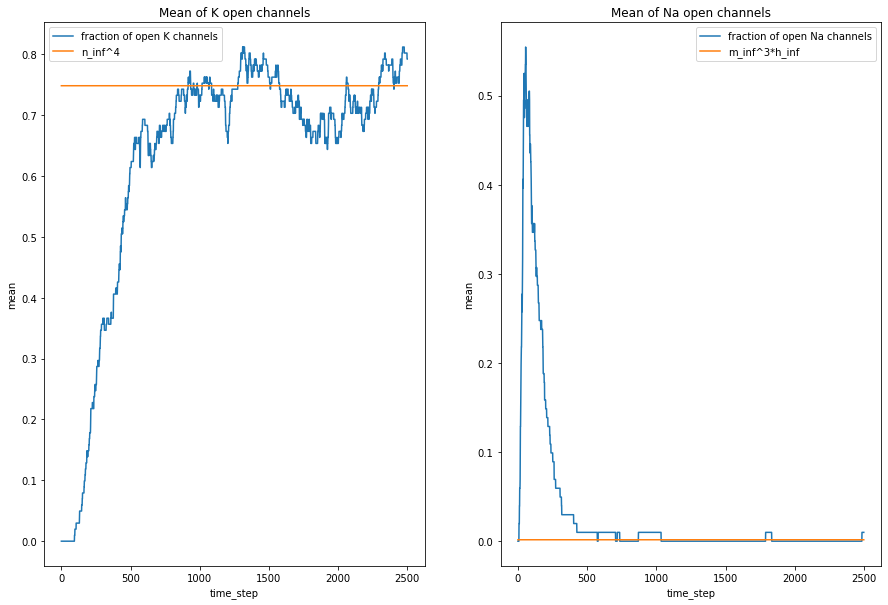

In [8]:
# Plotting
figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(k_avg, label='fraction of open K channels')
plt.plot(n_inf_line, label='n_inf^4')
plt.ylabel('mean')
plt.xlabel('time_step')
plt.title('Mean of K open channels')
plt.legend()

plt.subplot(1,2,2)
plt.plot(na_avg, label='fraction of open Na channels')
plt.plot(mh_inf_line, label='m_inf^3*h_inf')
plt.ylabel('mean')
plt.xlabel('time_step')
plt.title('Mean of Na open channels')
plt.legend()

plt.show()

#### 4.4) Plotting the variance for different populations of K and Na for a fixed *voltage* V=10mV

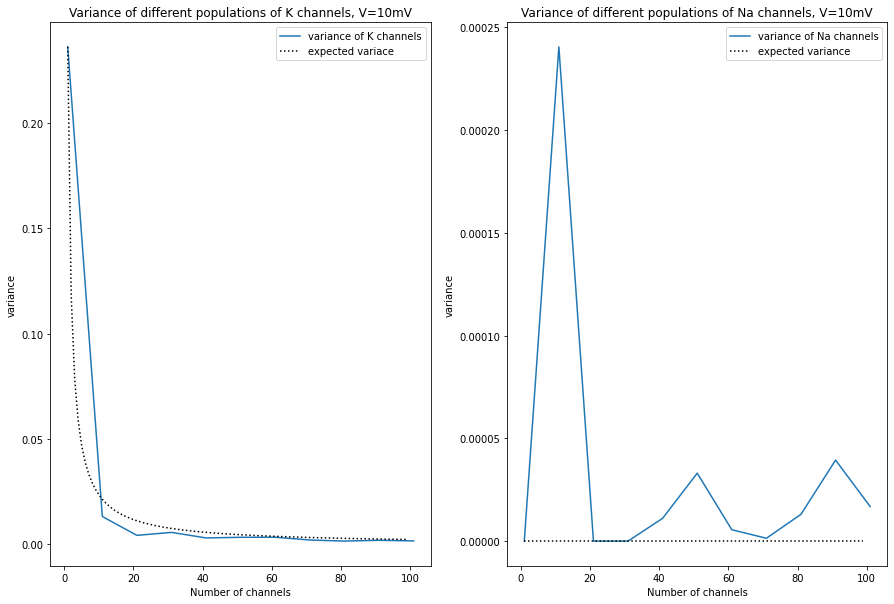

In [9]:
# Plotting
figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(N, k_variances, label='variance of K channels')
plt.plot(range(N_max), k_expected_varaince, ls=":", c="k", label='expected variace')
plt.ylabel('variance')
plt.xlabel('Number of channels')
plt.title('Variance of different populations of K channels, V=10mV')
plt.legend()

plt.subplot(1,2,2)
plt.plot(N, na_variances, label='variance of Na channels')
plt.plot(range(N_max), na_expected_varaince, ls=":", c="k", label='expected variance')
plt.ylabel('variance')
plt.xlabel('Number of channels')
plt.title('Variance of different populations of Na channels, V=10mV')
plt.legend()

plt.show()

#### 4.5) Calculating mean for different voltages, for a fixed population N=300 channels

In [10]:
N = 200
delta_t = 0.01

V_max = 30
voltages = np.arange(-101,40,10)
k_avgs = []
na_avgs = []
n_inf_lines = []
mh_inf_lines = []

for voltage in voltages:  
  k_population = [StochasticKChannel(initial_state=1) for x in range(N)]
  k_stochastic_pop = StochasticPopulation(k_population=k_population, initial_voltage=voltage, delta_t=delta_t)
  k_avg = k_stochastic_pop.go_stochastic(t_max=30)[0]
  k_avgs.append(np.mean(k_avg))
  n_inf_lines.append(n_inf(voltage)**4)
  
  na_population = [StochasticNAChannel(initial_state=1) for x in range(N)]
  na_stochastic_pop = StochasticPopulation(na_population=na_population, initial_voltage=voltage, delta_t=delta_t)
  na_avg = na_stochastic_pop.go_stochastic(t_max=30)[1]
  na_avgs.append(np.mean(na_avg))
  mh_inf_lines.append(m_inf(voltage)**3 * h_inf(voltage))




#### 4.6) Plotting the mean of the fraction of open K and Na channels for different voltages, fixed population of channels N=300

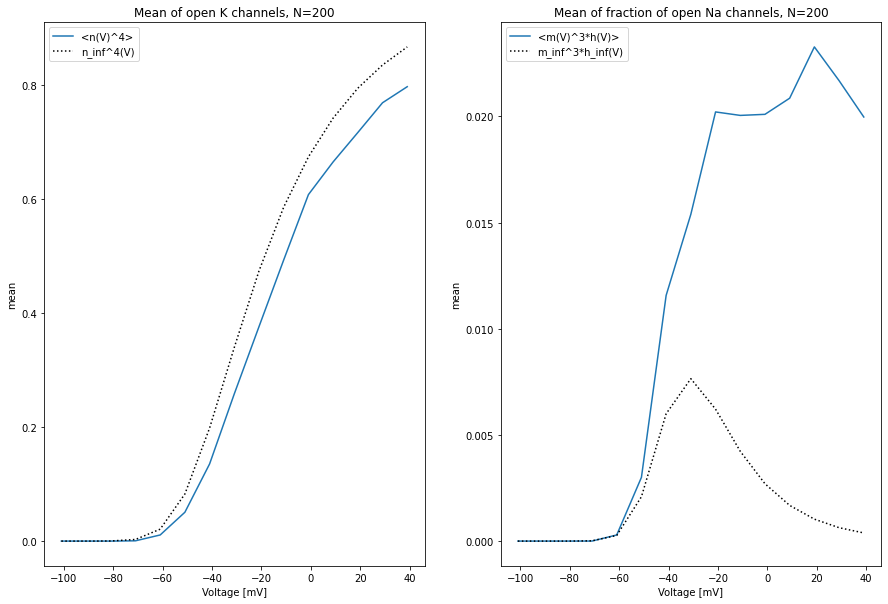

In [11]:
# Plotting
figure(figsize=(15,10))
#plt.subplots_adjust(wspace=0.5)
plt.subplot(1,2,1)
plt.plot(voltages, k_avgs, label='<n(V)^4>')
plt.plot(voltages, n_inf_lines, ls=":", c="k", label='n_inf^4(V)')
plt.ylabel('mean')
plt.xlabel('Voltage [mV]')
plt.title('Mean of open K channels, N=200')
plt.legend()

plt.subplot(1,2,2)
plt.plot(voltages, na_avgs, label='<m(V)^3*h(V)>')
plt.plot(voltages, mh_inf_lines, ls=":", c="k", label='m_inf^3*h_inf(V)')
plt.ylabel('mean')
plt.xlabel('Voltage [mV]')
plt.title('Mean of fraction of open Na channels, N=200')
plt.legend()

plt.show()

## 5) Comparison against Hodgkin-Huxley model

#### 5.1) Calculating the Hodgkin-Huxley current

In [12]:
def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-0.1 * (V + 55)))

def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-0.1 * (V + 40)))

def alpha_h(V):
    return 0.07 * np.exp(-0.05 * (V + 65))

def beta_n(V):
    return 0.125 * np.exp(-0.0125 * (V + 65))

def beta_m(V):
    return 4 * np.exp(-0.0556 * (V + 65))

def beta_h(V):
    return 1 / (1 + np.exp(-0.1 * (V + 35)))

def kinetic_equation_n(V, n):
    return alpha_n(V) * (1 - n) - beta_n(V) * n

def kinetic_equation_m(V, m):
    return alpha_m(V) * (1 - m) - beta_m(V) * m

def kinetic_equation_h(V, h):
    return alpha_h(V) * (1 - h) - beta_h(V) * h

# V in mV
def leak_current(V):
    return 0.3 * (V + 54.387) # S * 10^(-9) * V * 10^(-3) = A * 10^(-12) - picoAmper

# leave conductance in nS, in the end we will get pA
def potassium_current(V, n):
    return 36 * pow(n, 4) * (V - (-77))

def sodium_current(V, m, h):
    return 120 * pow(m, 3) * h * (V - 50)

def zero_injected_current(t):
    return 0

def HH_model(V, n, m, h, injected_current, t):
    C_m = 1 # pF
    # pA / pF = V
    return (-potassium_current(V, n) - sodium_current(V, m, h) - leak_current(V) + injected_current(t)) / C_m

# Write it with respect to current_t, V will change with t as in 1(c)
def euler(n_func, m_func, h_func, model_equation, injected_current, V_0, n_0, m_0, h_0, t_max, dt, update_voltage=False):
    timesteps = np.arange(dt, t_max, dt)
    
    n_solutions, I_K_solutions, m_solutions, h_solutions, I_Na_solutions = np.zeros(len(timesteps) + 1), \
                    np.zeros(len(timesteps) + 1), np.zeros(len(timesteps) + 1), \
                    np.zeros(len(timesteps) + 1), np.zeros(len(timesteps) + 1), \
    
    n_solutions[0] = n_0 # we did our first dt step there  
    m_solutions[0] = m_0
    h_solutions[0] = h_0
    I_K_solutions[0] = potassium_current(V_0, n_0)
    I_Na_solutions[0] = sodium_current(V_0, m_0, h_0)  
    voltage_solution = np.zeros(len(timesteps) + 1)
    voltage_solution[0] = V_0
    
    for idx, current_t in enumerate(timesteps):
        
        idx = idx + 1 # as we skip the initial condition step
        
        n_next = n_0 + n_func(V_0, n_0) * dt 
        n_0 = n_next
        n_solutions[idx] = n_0
        
        m_next = m_0 + m_func(V_0, m_0) * dt 
        m_0 = m_next
        m_solutions[idx] = m_0
        
        h_next = h_0 + h_func(V_0, h_0) * dt 
        h_0 = h_next
        h_solutions[idx] = h_0
        
        I_K = potassium_current(V_0, n_0)
        I_K_solutions[idx] = I_K
        
        I_Na = sodium_current(V_0, m_0, h_0)
        I_Na_solutions[idx] = I_Na
       
        if update_voltage:
          V_next = V_0 + model_equation(V_0, n_0, m_0, h_0, injected_current, current_t) * dt
        else:
          V_next = V_0

        V_0 = V_next
        voltage_solution[idx] = V_0
        
    return voltage_solution, n_solutions, m_solutions, h_solutions, I_K_solutions, I_Na_solutions   


#### 5.2) Comparing against different populations 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.05, 0.05, 0.06, 0.06, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.08, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.12, 0.12, 0.12, 0.12, 0.14, 0.14, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.15, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.17, 0.17, 0.17, 0.18, 0.19, 0.19, 0.19, 0.19, 0.2, 0.2, 0.21, 0.21, 0.21, 0.21, 0.22, 0.22, 0.22, 0.23, 0.24, 0.24, 0.24, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.24, 0.24, 0.24, 0

Text(0, 0.5, 'current Na [pA]')

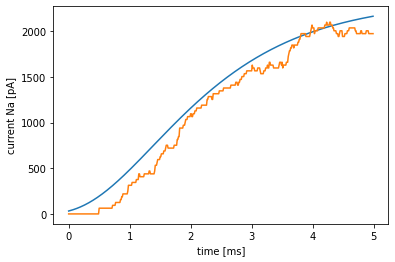

In [13]:
def current_k(voltage, mean_open_k):
  """
  The next line is based on n (HH model)
    return K_CONDUC * prob**4 * (self.voltage - K_REVERSAL)
  What we want though is current based on P (is channel open or no)
  """
  k_reversal = -77            # mV
  k_conduct = 36
  return k_conduct * mean_open_k * (voltage - k_reversal)

def current_na(voltage, mean_open_na):
  """
  The next line is based on n (HH model)
    return K_CONDUC * prob**4 * (self.voltage - K_REVERSAL)
  What we want though is current based on P (is channel open or no)
  """
  na_reversal = 50            # mV
  na_conduct   = 120   # Siemens
  return na_conduct * mean_open_na * (voltage - na_reversal)

voltage = 10

t_max = 5
delta_t = 0.01

n_0 = 0.3177
m_0 = 0.0529
h_0 = 0.5961

N_max = 100
step = 10
N = [100]
k_currents = []
na_currents = []

for n in N:  
  k_population = [StochasticKChannel(initial_state=1) for x in range(n)]
  k_stochastic_pop = StochasticPopulation(k_population=k_population, initial_voltage=voltage, delta_t=delta_t)
  k_avgs = k_stochastic_pop.go_stochastic(t_max=t_max)[0]
  k_currents.append([current_k(voltage, mean_k) for mean_k in k_avgs])
  
  na_population = [StochasticNAChannel(initial_state=1) for x in range(n)]
  na_stochastic_pop = StochasticPopulation(na_population=na_population, initial_voltage=voltage, delta_t=delta_t)
  na_avgs = na_stochastic_pop.go_stochastic(t_max=t_max)[1]
  na_currents.append([current_na(voltage, mean_na) for mean_na in na_avgs])

_, _, _, _, HH_current_k, HH_current_na = euler(kinetic_equation_n, kinetic_equation_m, kinetic_equation_h, HH_model, zero_injected_current, voltage, n_0, m_0, h_0, t_max, delta_t, update_voltage=False)

print(k_avgs)
print(k_currents[0])

timesteps = np.arange(0, t_max, delta_t)
plt.plot(timesteps, HH_current_k, label="HH model")
plt.plot(timesteps, k_currents[0], label="Stochastic")
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.xlabel("time [ms]")
plt.ylabel("current Na [pA]")

#### 5.3) Hodgkin-Huxley using Stochastic population vs gating variables

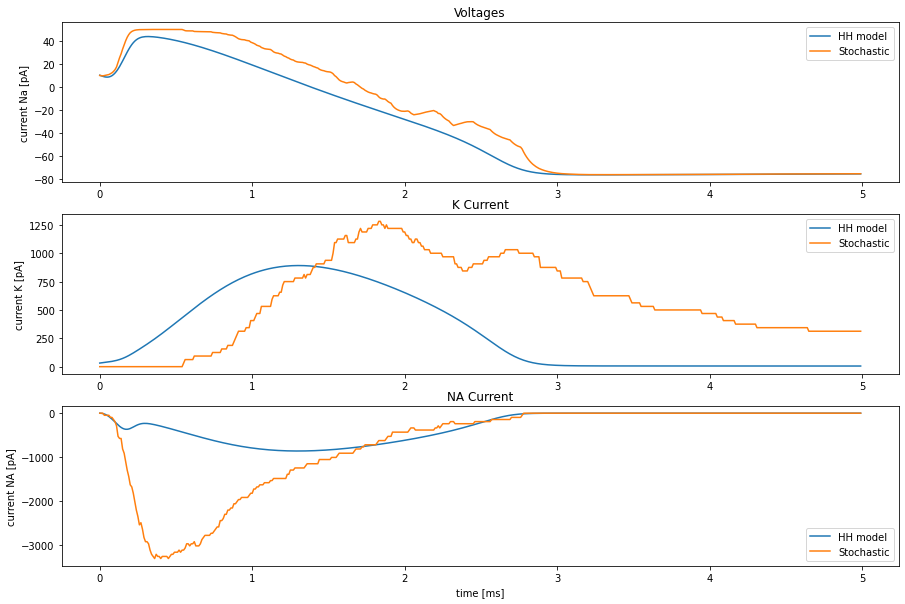

In [14]:
voltage = 10

t_max = 5
delta_t = 0.01

n_0 = 0.3177
m_0 = 0.0529
h_0 = 0.5961

population_size = 100

# 1. Initialize the populations
k_population = [StochasticKChannel(initial_state=1) for x in range(population_size)]
na_population = [StochasticNAChannel(initial_state=1) for x in range(population_size)]

# 2. Run stochastic
stochastic_pop = StochasticPopulation(k_population=k_population, na_population=na_population, initial_voltage=voltage, delta_t=delta_t)
stochastic_output = stochastic_pop.go_stochastic(t_max=t_max, update_voltage=True)

# 3. Get K, NA currents
k_avgs = stochastic_output[0]
na_avgs = stochastic_output[1]
k_currents = [current_k(voltage, mean_k) for mean_k in k_avgs]
na_currents = [current_na(voltage, mean_na) for mean_na in na_avgs]

# 4. Get voltages
stochastic_voltages = stochastic_output[2]

# 5. Run pure HH model (using Euler method)
hh_voltages, _, _, _, HH_current_k, HH_current_na = euler(kinetic_equation_n, kinetic_equation_m, kinetic_equation_h, HH_model, zero_injected_current, voltage, n_0, m_0, h_0, t_max, delta_t, update_voltage=True)


# 6. Plotting
timesteps = np.arange(0, t_max, delta_t)
figure(figsize=(15,10))

plt.subplot(3,1,1)
plt.plot(timesteps, hh_voltages, label="HH model")
plt.plot(timesteps, stochastic_voltages, label="Stochastic")
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.ylabel("current Na [pA]")
plt.title('Voltages')
plt.legend()

plt.subplot(3,1,2)
plt.plot(timesteps, HH_current_k, label="HH model")
plt.plot(timesteps, k_currents, label="Stochastic")
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.ylabel("current K [pA]")
plt.title('K Current')
plt.legend()

plt.subplot(3,1,3)
plt.plot(timesteps, HH_current_na, label="HH model")
plt.plot(timesteps, na_currents, label="Stochastic")
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.xlabel("time [ms]")
plt.ylabel("current NA [pA]")
plt.title('NA Current')
plt.legend()

plt.subplots_adjust(wspace=0.8)
plt.show()

----------------------------------------------------------------

1.   Plot current
    - Calculate the current on every step
    - Using the reversal potential and conducatnce (na, k)
2.   Include the hh_euler method to calculate the current
3.   Plugging the values of current from our stochastic model and plug it into  the hh model  
4. Calculate the ISI
